## En local se trabajo con pySpark y paython por el gran volumen de datos a manipular.

In [ ]:
# Importa las librerias necesarias

import pandas as pd
import pickle
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, sum, count
from pyspark.sql.functions import input_file_name, regexp_extract
from pyspark.sql.types import StructType, StructField, StringType, LongType
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [20]:
reviews = pd.read_csv("/content/drive/MyDrive/Yelp_reviews_final.csv", sep=";")


In [ ]:
reviews

,id_reviews,id_user,id_source,stars,id_date,review,likes,source
0,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3,0,Had a party of 6 here for hibachi. Our waitres...,0,1
1,OAhBYw8IQ6wlfw1owXWRWw,1C2lxzUo1Hyye4RFIXly3g,BVndHaLihEYbr76Z0CMEGw,5,0,"Great place for breakfast! I had the waffle, w...",0,1
2,eCiWBf1CJ0Zdv1uVarEhhw,OhECKhQEexFypOMY6kypRw,vC2qm1y3Au5czBtbhc-DNw,4,0,"Yes, this is the only sushi place in town. How...",0,1
3,YbMyvlDA2W3Py5lTz8VK-A,4hBhtCSgoxkrFgHa4YAD-w,bbEXAEFr4RYHLlZ-HFssTA,5,0,"Great burgers,fries and salad! Burgers have a...",0,1
4,L0jv8c2FbpWSlfNC6bbUEA,bFPdtzu11Oi0f92EAcjqmg,IDtLPgUrqorrpqSLdfMhZQ,5,0,What a great addition to the Funk Zone! Grab ...,0,1
...,...,...,...,...,...,...,...,...
1481660,_USUb1lBWnO4VV58FHL6fw,ik0UUieUX38rPg24heeVgw,6aUb_f9C7a2oOxaIfRGSdA,4,0,I ordered a half rack of Pork Ribs (a la carte...,1,1
1481661,pJvL9AN6gDoixiLLNF1c7w,nsTmZRhVzY5YahKZQkAPbw,r2IhvKZQ_wLR5mLBnPOilg,4,0,One of my favorite restaurants in Santa Barbar...,8,1
1481662,34M6AEbY84174OBerbm96Q,i48cHEyRBl5g9_npYIG7dA,ReVpjIDupK_VMPn7ZxPvOQ,4,0,This place never fails the food is absolutely ...,3,1
1481663,PVRvzY0NxSU-fiK3JOXX7w,cTozFTTWjlFYc3yusdbZmA,uMVOtr16r1ELu46pWr4HCQ,1,0,Just average Thai food tonight. Bangkok has al...,0,1


In [21]:
google_shops = pd.read_csv("/content/drive/MyDrive/google_shops.csv", sep=";")

google_shops

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,...,Health & safety,Popular for,Dining options,Crowd,Planning,Highlights,From the business,Recycling,Getting here,Activities
0,City Textile,"City Textile, 3001 E Pico Blvd, Los Angeles, C...",0x80c2c98c0e3c16fd:0x29ec8a728764fdf9,NaN,34.018891,-118.215290,['Textile exporter'],4.5,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,San Soo Dang,"San Soo Dang, 761 S Vermont Ave, Los Angeles, ...",0x80c2c778e3b73d33:0xbdc58662a4a97d49,NaN,34.058092,-118.292130,['Korean restaurant'],4.4,18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nova Fabrics,"Nova Fabrics, 2200 E 11th St, Los Angeles, CA ...",0x80c2c89923b27a41:0x32041559418d447,NaN,34.023669,-118.232930,['Fabric store'],3.3,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Nobel Textile Co,"Nobel Textile Co, 719 E 9th St, Los Angeles, C...",0x80c2c632f933b073:0xc31785961fe826a6,NaN,34.036694,-118.249421,['Fabric store'],4.3,7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Matrix International Textiles,"Matrix International Textiles, 1363 S Bonnie B...",0x80c2cf163db6bc89:0x219484e2edbcfa41,NaN,34.015505,-118.181839,['Fabric store'],3.5,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536511,A-Plus Quality Services & Repair,"A-Plus Quality Services & Repair, 630 Oak Pl #...",0x88e6d81f3e448fab:0xbfa0a5f75e4ab85f,NaN,29.133834,-80.990282,['Auto repair shop'],4.4,15,NaN,...,NaN,NaN,NaN,NaN,['Appointments recommended'],NaN,NaN,NaN,NaN,NaN
536512,COA New Smyrna Beach Neighborhood Activity Cen...,COA New Smyrna Beach Neighborhood Activity Cen...,0x88e72855dcc6f519:0x66e6952d4bce4ca1,NaN,29.015365,-80.919734,['Senior citizen center'],4.0,17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536513,Subpreme Grill,"Subpreme Grill, 15260 SW 280th St UNIT 111, Ho...",0x88d9dd6e78851851:0x849dcf273582261c,NaN,25.506121,-80.438215,"['Sandwich shop', 'Fast food restaurant', 'Tak...",4.3,393,$,...,NaN,"['Lunch', 'Dinner', 'Solo dining']",['Dessert'],"['College students', 'Groups', 'Tourists']",NaN,NaN,NaN,NaN,NaN,NaN
536514,Enterprise Rent-A-Car,"Enterprise Rent-A-Car, 33521 S Dixie Hwy, Home...",0x88d9e749a61cd6a5:0x7396cf8e8dadf8bf,NaN,25.455505,-80.474782,"['Car rental agency', 'Van rental agency']",4.2,158,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,['Identifies as women-led'],NaN,NaN,NaN


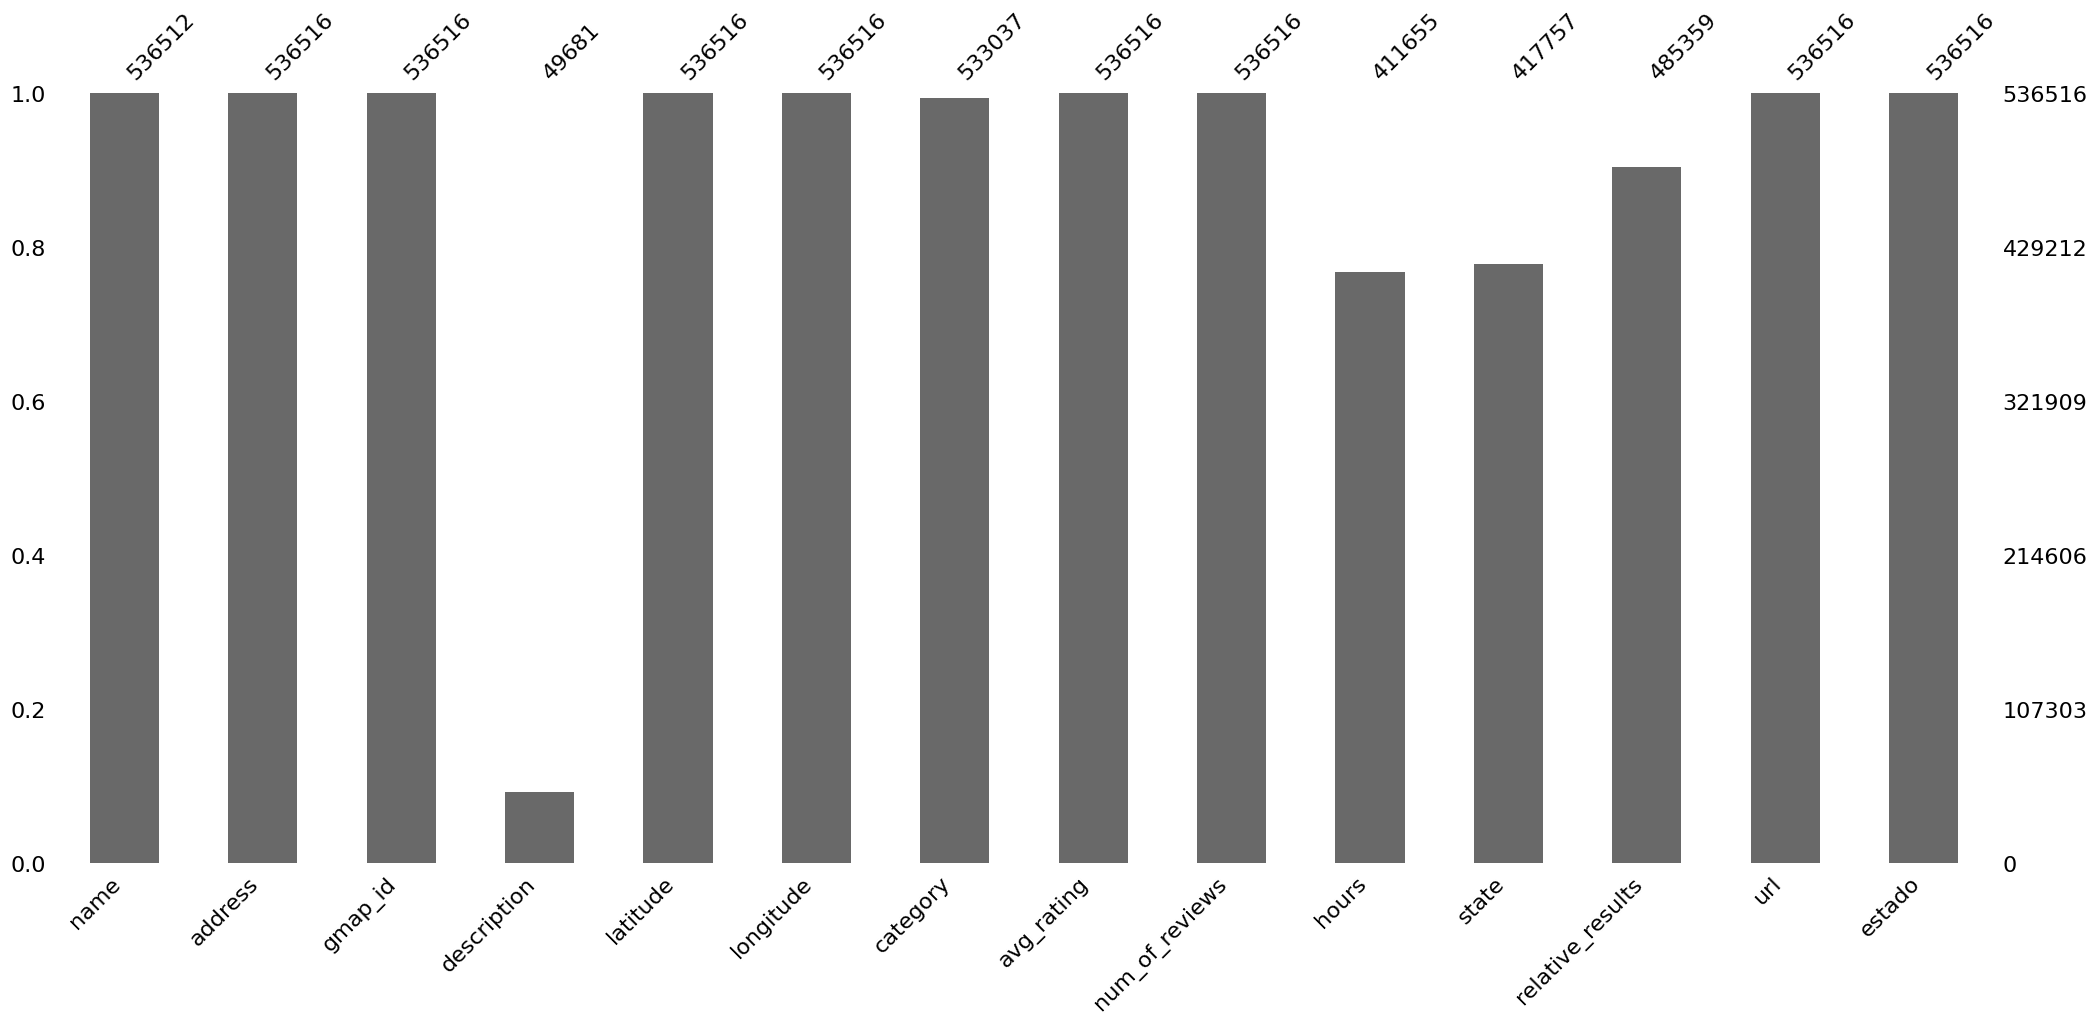

In [23]:
import missingno as msno
import matplotlib.pyplot as plt

msno.bar(google_shops)
plt.show()

In [22]:


# Lista de columnas a eliminar
columns_to_drop = ['price', 'Service options', 'Accessibility', 'Offerings', 'Amenities', 'Atmosphere',
                   'Payments', 'Health & safety', 'Popular for', 'Dining options', 'Crowd', 'Planning',
                   'Highlights', 'From the business', 'Recycling', 'Getting here', 'Activities']

# Elimina las columnas
google_shops = google_shops.drop(columns=columns_to_drop)


In [24]:
new_business = pd.read_csv("/content/drive/MyDrive/new_business.csv", sep=";")

new_business

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,['ByAppointmentOnly': 'True'],"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,['BusinessAcceptsCreditCards': 'True'],"Shipping Centers, Local Services, Notaries, Ma...","['Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,NaN,85711,32.223236,-110.880452,3.5,22,0,"['BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","['Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"['RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","['Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,1,"['BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","['Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,IN,T6J 5H2,53.468419,-113.492054,3.0,13,1,"['ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","['Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,DE,37204,36.115118,-86.766925,4.0,5,1,"['BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","['Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,AB,46250,39.908707,-86.065088,3.5,8,1,"['RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",NaN
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,AB,62025,38.782351,-89.950558,4.0,24,1,"['BusinessParking': ['garage': False, 'street'...","Fitness/Exercise Equipment, Eyewear & Optician...","['Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


In [25]:
Yelp_reviews1 = pd.read_csv("/content/drive/MyDrive/Yelp_reviews.csv", sep=",")

Yelp_reviews1

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,0,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
1,1,TP0HYy4GqYtrWMlFIhxw3A,YRsNXrlyvjnr7NLSDwen0Q,LHSTtnW3YHCeUkRDGyJOyw,1,4,2,0,We arrived a few minutes early for a 7pm reser...,2016-05-31 01:58:22
2,2,RkXe6gzU6bfut_Q2W2NpbA,jPaGpFevnH4y1BQGIe3glw,LHSTtnW3YHCeUkRDGyJOyw,5,0,0,0,This is one of my favorite restaurants. They h...,2017-12-02 23:28:30
3,3,Wv6ty8iRgaPtqRzQXQiDaA,V0RkSHN5nckzO6oPTCp6mw,LHSTtnW3YHCeUkRDGyJOyw,4,0,0,0,Let me start by saying that my wife and I are ...,2018-03-23 23:22:00
4,4,w0cb9xwH5KSgtTpP3DcIVg,yujZWE_uZn41f5-677Gvjg,LHSTtnW3YHCeUkRDGyJOyw,4,1,0,0,I wrote this a while ago but never posted it f...,2016-01-30 15:55:07
...,...,...,...,...,...,...,...,...,...,...
1820140,1820140,Rua2-9R0jNk2sAN6JdM43g,n9B9grVJBm0nSvKj0wTBNw,NSoT9z12S2wgJsZR-jfLRA,1,1,0,0,My package has been stuck in transit since Jan...,2022-01-14 22:39:21
1820141,1820141,to_ufQVO5UcKGEMsD1v8pw,OGey37DSAw5z6LLqafSt5A,NSoT9z12S2wgJsZR-jfLRA,1,1,0,0,I paid for an order to Shein on May 28th. (NOT...,2021-07-08 21:15:32
1820142,1820142,09Q32HZZf2_vJFnyHtYouQ,agyJKcnXp4PF9QBfCAKfXA,NSoT9z12S2wgJsZR-jfLRA,5,1,0,0,l A very nice driver. When I was on vacation a...,2022-01-15 20:02:35
1820143,1820143,1WYnufgEcMknv_wGI6zmCg,OGey37DSAw5z6LLqafSt5A,NSoT9z12S2wgJsZR-jfLRA,5,3,1,1,Literally like 20 minutes after i wrote a bunc...,2021-07-14 04:57:51


In [26]:
users = pd.read_csv("/content/drive/MyDrive/Yelp_users.csv", sep=",")
users.head()

,Unnamed: 0,user_id,name,review_count,useful,funny,cool,elite,fans,average_stars,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,7217,1259,5994,2007,267,3.91,...,65,55,56,18,232,844,467,467,239,180
1,1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3138,3.74,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2086,1010,1003,"2009,2010,2011,2012,2013",52,3.32,...,13,10,17,3,66,96,119,119,35,18
3,3,SZDeASXq7o05mMNLshsdIA,Gwen,224,512,330,299,"2009,2010,2011",28,4.27,...,4,1,6,2,12,16,26,26,10,9
4,4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,29,15,7,NaN,1,3.54,...,1,0,0,0,1,1,0,0,0,0


In [ ]:
FL = pd.read_csv("/content/drive/MyDrive/FL_reviews.csv", sep=",")

FL

,Unnamed: 0,user_id,name,time,rating,text,gmap_id
0,0,1.014719e+20,Julie A. Gerber,1628003250740,1,Update: Their “reply” to my review amounted to...,0x8893863ea87bd5dd:0x9383ebf973e74abb
1,1,1.154772e+20,Martin Sheffield,1595031217005,5,He's a knowledgeable doctor but the way he run...,0x8893863ea87bd5dd:0x9383ebf973e74abb
2,2,1.018050e+20,Brian Truett,1522924253567,5,"Best doctor I've ever had, I never wait to be ...",0x8893863ea87bd5dd:0x9383ebf973e74abb
3,3,1.063444e+20,Tina Sun,1467907819586,1,I was told he is a good doctor. I was trying t...,0x8893863ea87bd5dd:0x9383ebf973e74abb
4,4,1.008751e+20,James Haynes,1480683415081,5,Takes the time to actually get to know his pat...,0x8893863ea87bd5dd:0x9383ebf973e74abb
...,...,...,...,...,...,...,...
2849995,2849995,1.039909e+20,J. B. Oliveira,1503293272680,5,It is a buyers paradise. Hundred places inside...,0x88d908feeaeded1f:0x29c1bf6101ce3a42
2849996,2849996,1.124797e+20,Adam K,1514763473117,5,Great place to go especially if you're in the ...,0x88d908feeaeded1f:0x29c1bf6101ce3a42
2849997,2849997,1.103771e+20,English People,1531250213447,5,I love this place so much and come here alot a...,0x88d908feeaeded1f:0x29c1bf6101ce3a42
2849998,2849998,1.099194e+20,Shiva K,1532621720862,4,"Plenty of shops with excellent variety, ample ...",0x88d908feeaeded1f:0x29c1bf6101ce3a42


**Imprimo todas las columnas para facilitar el armado de las tablas con las columnas necesarias para el analisis.**

In [ ]:
google_shops.columns

Index(['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude',
       'category', 'avg_rating', 'num_of_reviews', 'hours', 'state',
       'relative_results', 'url', 'estado'],
      dtype='object')

In [ ]:
reviews.columns

Index(['id_reviews', 'id_user', 'id_source', 'stars', 'id_date', 'review',
       'likes', 'source'],
      dtype='object')

In [ ]:
new_business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [ ]:
Yelp_reviews1.columns

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date'],
      dtype='object')

In [ ]:
users.columns

Index(['Unnamed: 0', 'user_id', 'name', 'review_count', 'useful', 'funny',
       'cool', 'elite', 'fans', 'average_stars', 'compliment_hot',
       'compliment_more', 'compliment_profile', 'compliment_cute',
       'compliment_list', 'compliment_note', 'compliment_plain',
       'compliment_cool', 'compliment_funny', 'compliment_writer',
       'compliment_photos'],
      dtype='object')

In [ ]:
FL.columns

Index(['Unnamed: 0', 'user_id', 'name', 'time', 'rating', 'text', 'gmap_id'], dtype='object')

## KPIs 1  superar el promedio de reviews positivas de restaurantes top 20 de florida para 2025.

## Como se calcula:

$$
\text{Promedio de Opiniones Positivas} = \frac{\text{Opiniones Positivas}}{\text{Total Opiniones}}
$$


In [ ]:
florida_restaurants = new_business[new_business['state'] == 'FL']

# Ordenar por calificación y número de reseñas
top_restaurants = florida_restaurants.sort_values(by=['stars', 'review_count'], ascending=False)

# Seleccionar los 20 primeros
top_20 = top_restaurants.head(20)

top_20

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
134154,8QqnRpM-QxGsjDNuu0E57A,Carlillos Cocina,415 S Rock Blvd,Sparks,FL,89431,39.530096,-119.766608,5.0,799,1,"['NoiseLevel': ""u'average'"", 'GoodForMeal': ['...","Bars, Mexican, Breakfast & Brunch, Restaurants...","['Monday': '7:0-14:0', 'Tuesday': '7:0-14:0', ..."
25015,zxIF-bnaJ-eKIsznB7yu7A,Free Tours By Foot,2613 Laurel St,New Orleans,FL,70130,29.925353,-90.079988,5.0,769,1,"['WiFi': ""u'no'""]","Hotels & Travel, Walking Tours, Tours","['Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."
33175,tARR9jhv5gi9TjsfSVmjmw,Kaffe Crepe,"1300 East Plumb Ln, Ste C4",Reno,FL,89502,39.504208,-119.782768,5.0,454,1,"['Caters': 'False', 'HasTV': 'False', 'GoodFor...","Food, Restaurants, Cafes, Creperies, Coffee & Tea","['Monday': '9:0-15:0', 'Tuesday': '8:0-16:0', ..."
84744,u3zqvp4BYUjzJD7tzx3Jbg,JB Plumbing and Heating,NaN,Philadelphia,FL,19107,39.955929,-75.157457,5.0,398,1,"['BusinessAcceptsCreditCards': 'True', 'ByAppo...","Plumbing, Water Heater Installation/Repair, Ex...","['Monday': '0:0-0:0', 'Tuesday': '6:0-18:0', '..."
143760,yOoTTOsIBk10XCszYVnrDQ,AJ's Press,3224 W Tampa Bay Blvd,Tampa,FL,33614,27.973812,-82.496982,5.0,376,0,"['RestaurantsTakeOut': 'True', 'NoiseLevel': ""...","American (New), Cafes, Restaurants, Breakfast ...",NaN
130633,NDwoKO79_T49UEKVDlHd3A,Sustainable Wine Tours,"27 West Anapamu St, Ste 104",Santa Barbara,FL,93101,34.422452,-119.705021,5.0,358,1,"['GoodForKids': 'False', 'BusinessAcceptsCredi...","Wine Tours, Hotels & Travel, Tours, Transporta...","['Monday': '0:0-0:0', 'Tuesday': '7:0-20:0', '..."
7094,qjGS_7iaQDpbVhS6W8qkHQ,The Sweet Life Bakeshop,740 South St,Philadelphia,FL,19147,39.942203,-75.155223,5.0,316,1,"['BusinessAcceptsBitcoin': 'False', 'NoiseLeve...","Food, Cupcakes, Desserts, Bakeries","['Monday': '0:0-0:0', 'Tuesday': '11:0-18:30',..."
86364,aAXo_vX8YG10kytAM9SC9Q,Ice Dreammm Shop,"23912 State Rd 54, Ste 2",Lutz,FL,33559,28.185100,-82.421468,5.0,306,1,"['DogsAllowed': 'False', 'DriveThru': 'False',...","Desserts, Ice Cream & Frozen Yogurt, Food","['Monday': '12:0-21:0', 'Tuesday': '12:0-21:0'..."
102283,Og4z8nB4ZMZs3oHkVhB_pA,Bobby Mack & Co Hair Studio,1944 S St,Philadelphia,FL,19146,39.944711,-75.174965,5.0,291,1,"['GoodForKids': 'True', 'BusinessParking': ['g...","Hair Salons, Men's Hair Salons, Hair Stylists,...","['Monday': '0:0-0:0', 'Tuesday': '9:0-19:0', '..."
103038,0IjDqJexP6jTH4F_Kg4mrQ,A New Twist Balloons and Face Painting,NaN,Boise,FL,83725,43.605485,-116.207150,5.0,276,1,"['BusinessAcceptsCreditCards': 'True', 'Busine...","Event Planning & Services, Face Painting, Fest...","['Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


## cada fila en top_20_yelp_reviews representa una reseña de Yelp para uno de los 20 restaurantes principales, e incluye información como el ID de la reseña, el ID del usuario que dejó la reseña, el ID del restaurante que fue revisado, la calificación en estrellas de la reseña, y el texto de la reseña

In [ ]:
# Extrae los 'business_id' de los 20 principales negocios.
top_20_ids = top_20['business_id']

# Filtra las revisiones para incluir solo aquellas asociadas con los 20 principales 'business_id'.
top_20_reviews = reviews[reviews['id_reviews'].isin(top_20_ids)]

# Filtra las revisiones de Yelp para incluir solo aquellas asociadas con los 20 principales 'business_id'.
top_20_yelp_reviews = Yelp_reviews1[Yelp_reviews1['business_id'].isin(top_20_ids)]



In [ ]:
#top_20_reviews
top_20_yelp_reviews

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
48640,48640,M7AGmOpm0PzSdSmP8dA_3A,OXmETnil1QAshKPioX8qjg,qjGS_7iaQDpbVhS6W8qkHQ,5,2,0,0,This place is absolutely amazing. A cute littl...,2016-01-17 06:11:00
48641,48641,aQDnom95pIKFR5XmrKeeGQ,h2_o_wDA1Ia3se4EMWTjFg,qjGS_7iaQDpbVhS6W8qkHQ,5,2,0,0,"They don't just have great cookies, cupcakes, ...",2017-12-16 16:23:25
48642,48642,BDGolw2FoOD78Kcg8tl1PQ,eL-d16Ky9-nFuAQ3SUBQZg,qjGS_7iaQDpbVhS6W8qkHQ,5,0,0,0,Banana pudding is amazing. You can get the ext...,2018-06-26 18:28:36
48643,48643,iNDpTF1SWzwJl58MUczWZA,M31SPnvR4eO9f1e5AF6alg,qjGS_7iaQDpbVhS6W8qkHQ,5,0,0,0,Delicious red velvet cupcakes!!! Absolutely a ...,2017-04-30 15:49:04
48644,48644,c9nDklltvNTdMJVFVStapQ,lQ8UjCCmJFmwZXUwL9g6dg,qjGS_7iaQDpbVhS6W8qkHQ,5,0,0,0,I had no idea pudding could be this good! I we...,2015-08-19 12:12:08
...,...,...,...,...,...,...,...,...,...,...
1803191,1803191,ZqYLdTkB9zROboF9dlKLOQ,HHWF8R88H0ketERdq1BGFQ,4bNFWpQtS5PtfjXuxTc-GQ,5,1,0,0,Amazing bakery and coffee shop--tucked away on...,2021-12-04 20:15:47
1803192,1803192,QdrLLTLT1fSs-kZpqO6bhw,ENob_LVAk-FqNJ5-PB5Ufg,4bNFWpQtS5PtfjXuxTc-GQ,5,4,1,1,Great spot for bakery goods and bubble tea. T...,2021-09-26 22:49:18
1803193,1803193,OGqqXaWmeP-jaWY5TnDESQ,la7yUSiANzCI1mNjMkKT6A,4bNFWpQtS5PtfjXuxTc-GQ,5,2,0,1,Was in Missouri for the week during Thanksgivi...,2020-12-20 16:51:57
1803194,1803194,VZwLHFLzu6WvIiWRbQs_KA,mB1XmpP_Nq6YCrnvndVOUQ,4bNFWpQtS5PtfjXuxTc-GQ,3,2,0,0,Taro boba was good. Not like other places uses...,2019-05-02 04:44:05


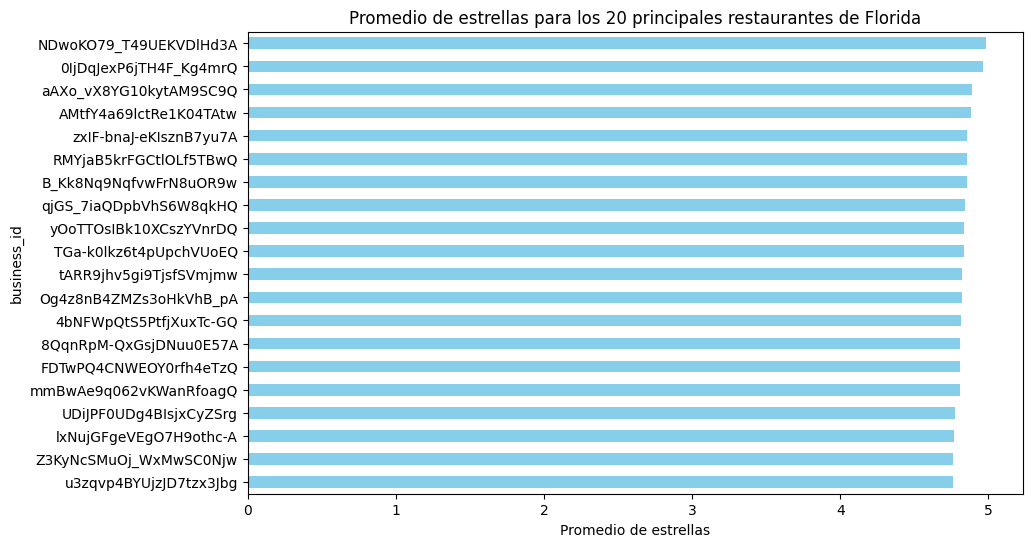

In [ ]:
# Calcular el promedio de estrellas para cada negocio
avg_stars = top_20_yelp_reviews.groupby('business_id')['stars'].mean()

# Crear un gráfico de barras de los promedios
plt.figure(figsize=(10, 6))
avg_stars.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Promedio de estrellas')
plt.title('Promedio de estrellas para los 20 principales restaurantes de Florida')
plt.show()

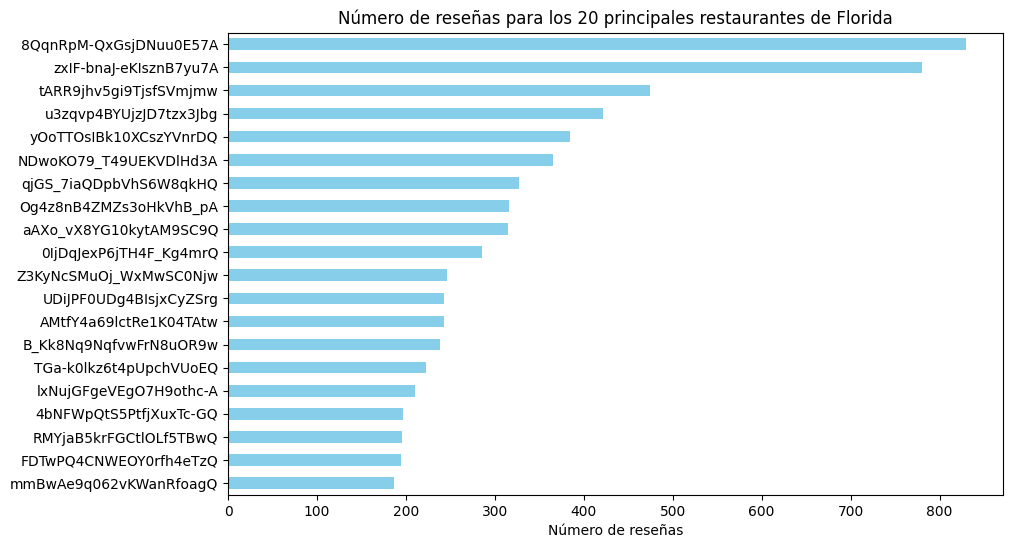

In [ ]:
# Calcular el número de reseñas para cada negocio
review_counts = top_20_yelp_reviews['business_id'].value_counts()

# Crear un gráfico de barras de los conteos de reseñas
plt.figure(figsize=(10, 6))
review_counts.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Número de reseñas')
plt.title('Número de reseñas para los 20 principales restaurantes de Florida')
plt.show()

## Nos ayudara a entender mejor el rendimiento de estos restaurantes y a plantear propuestas de negocios. Por ejemplo, se podría proponer estrategias para mejorar las calificaciones de los restaurantes que tienen un promedio de estrellas más bajo o para aumentar el número de reseñas de los restaurantes que tienen menos reseñas.

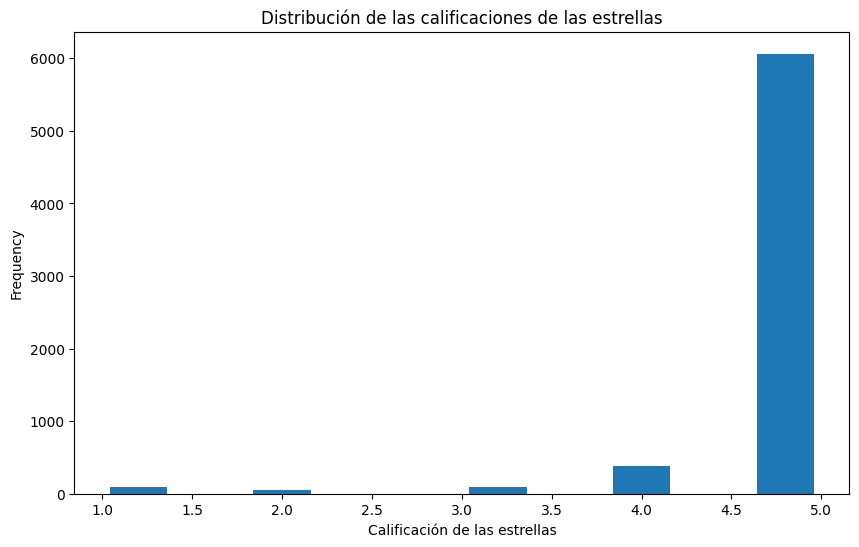

In [ ]:
plt.figure(figsize=(10, 6))
top_20_yelp_reviews['stars'].plot(kind='hist', rwidth=0.8)
plt.xlabel('Calificación de las estrellas')
plt.title('Distribución de las calificaciones de las estrellas')
plt.show()


## Visualiza la distribución de las calificaciones de las reseñas. Esto podría ayudarnos a entender si la mayoría de las reseñas son positivas, negativas o neutrales.

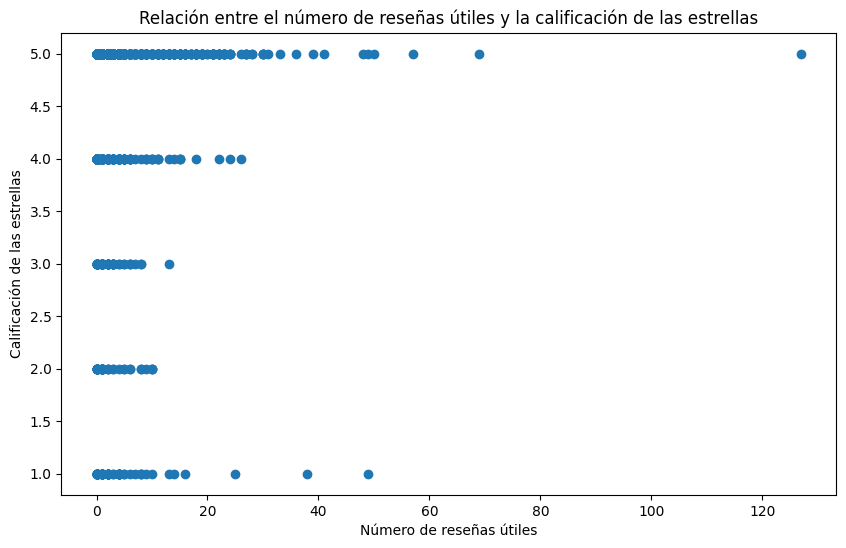

In [ ]:
# Crea un gráfico de dispersión que muestra la relación entre el número de reseñas útiles y la calificación de las estrellas.
plt.figure(figsize=(10, 6))
plt.scatter(top_20_yelp_reviews['useful'], top_20_yelp_reviews['stars'])
plt.xlabel('Número de reseñas útiles')
plt.ylabel('Calificación de las estrellas')
plt.title('Relación entre el número de reseñas útiles y la calificación de las estrellas')
plt.show()


## Hay una mayor concentración de reseñas útiles en las calificaciones de estrellas más altas, especialmente en 5.0 estrellas. Esto podría indicar que las reseñas de productos o servicios altamente calificados tienden a ser más útiles para otros usuarios.
## Las otras calificaciones tienen menos puntos, lo que indica menos reseñas útiles comparadas con las calificaciones más altas.

## Esto podría sugerir que los productos o servicios con calificaciones más altas tienden a recibir más reseñas útiles. Esto podría ser útil para las empresas al tratar de aumentar la utilidad de sus reseñas, ya que podrían centrarse en mejorar sus calificaciones para aumentar la probabilidad de recibir reseñas útiles.

## KPI 2 superar el promedio de reviews positivas de restaurantes top 10 de florida para 2026

## Se calcula:


  $$
\text{Promedio de Opiniones Positivas} = \frac{\text{Opiniones Positivas}}{\text{Total Opiniones}} \times 100
$$

In [ ]:
# Filtrar los restaurantes en Florida
florida_restaurants = new_business[new_business['state'] == 'FL']

# Ordenar por calificación y número de reseñas
top_restaurants = florida_restaurants.sort_values(by=['stars', 'review_count'], ascending=False)

# Seleccionar los 10 primeros
top_10 = top_restaurants.head(10)

top_10

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
134154,8QqnRpM-QxGsjDNuu0E57A,Carlillos Cocina,415 S Rock Blvd,Sparks,FL,89431,39.530096,-119.766608,5.0,799,1,"['NoiseLevel': ""u'average'"", 'GoodForMeal': ['...","Bars, Mexican, Breakfast & Brunch, Restaurants...","['Monday': '7:0-14:0', 'Tuesday': '7:0-14:0', ..."
25015,zxIF-bnaJ-eKIsznB7yu7A,Free Tours By Foot,2613 Laurel St,New Orleans,FL,70130,29.925353,-90.079988,5.0,769,1,"['WiFi': ""u'no'""]","Hotels & Travel, Walking Tours, Tours","['Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."
33175,tARR9jhv5gi9TjsfSVmjmw,Kaffe Crepe,"1300 East Plumb Ln, Ste C4",Reno,FL,89502,39.504208,-119.782768,5.0,454,1,"['Caters': 'False', 'HasTV': 'False', 'GoodFor...","Food, Restaurants, Cafes, Creperies, Coffee & Tea","['Monday': '9:0-15:0', 'Tuesday': '8:0-16:0', ..."
84744,u3zqvp4BYUjzJD7tzx3Jbg,JB Plumbing and Heating,NaN,Philadelphia,FL,19107,39.955929,-75.157457,5.0,398,1,"['BusinessAcceptsCreditCards': 'True', 'ByAppo...","Plumbing, Water Heater Installation/Repair, Ex...","['Monday': '0:0-0:0', 'Tuesday': '6:0-18:0', '..."
143760,yOoTTOsIBk10XCszYVnrDQ,AJ's Press,3224 W Tampa Bay Blvd,Tampa,FL,33614,27.973812,-82.496982,5.0,376,0,"['RestaurantsTakeOut': 'True', 'NoiseLevel': ""...","American (New), Cafes, Restaurants, Breakfast ...",NaN
130633,NDwoKO79_T49UEKVDlHd3A,Sustainable Wine Tours,"27 West Anapamu St, Ste 104",Santa Barbara,FL,93101,34.422452,-119.705021,5.0,358,1,"['GoodForKids': 'False', 'BusinessAcceptsCredi...","Wine Tours, Hotels & Travel, Tours, Transporta...","['Monday': '0:0-0:0', 'Tuesday': '7:0-20:0', '..."
7094,qjGS_7iaQDpbVhS6W8qkHQ,The Sweet Life Bakeshop,740 South St,Philadelphia,FL,19147,39.942203,-75.155223,5.0,316,1,"['BusinessAcceptsBitcoin': 'False', 'NoiseLeve...","Food, Cupcakes, Desserts, Bakeries","['Monday': '0:0-0:0', 'Tuesday': '11:0-18:30',..."
86364,aAXo_vX8YG10kytAM9SC9Q,Ice Dreammm Shop,"23912 State Rd 54, Ste 2",Lutz,FL,33559,28.185100,-82.421468,5.0,306,1,"['DogsAllowed': 'False', 'DriveThru': 'False',...","Desserts, Ice Cream & Frozen Yogurt, Food","['Monday': '12:0-21:0', 'Tuesday': '12:0-21:0'..."
102283,Og4z8nB4ZMZs3oHkVhB_pA,Bobby Mack & Co Hair Studio,1944 S St,Philadelphia,FL,19146,39.944711,-75.174965,5.0,291,1,"['GoodForKids': 'True', 'BusinessParking': ['g...","Hair Salons, Men's Hair Salons, Hair Stylists,...","['Monday': '0:0-0:0', 'Tuesday': '9:0-19:0', '..."
103038,0IjDqJexP6jTH4F_Kg4mrQ,A New Twist Balloons and Face Painting,NaN,Boise,FL,83725,43.605485,-116.207150,5.0,276,1,"['BusinessAcceptsCreditCards': 'True', 'Busine...","Event Planning & Services, Face Painting, Fest...","['Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


In [ ]:
# Obtener los business_id de los restaurantes top 10
top_10_ids = top_10['business_id']

# Filtrar las reseñas correspondientes en los dataframes reviews y Yelp_reviews1
top_10_reviews = reviews[reviews['id_source'].isin(top_10_ids)]
top_10_yelp_reviews = Yelp_reviews1[Yelp_reviews1['business_id'].isin(top_10_ids)]

In [ ]:
top_10_reviews

,id_reviews,id_user,id_source,stars,id_date,review,likes,source
290699,kNFkbqDtM0iAkubpiUqNBA,2ox0SHyoE81_Dnp6J_uC9w,tARR9jhv5gi9TjsfSVmjmw,5,0,New and yummy! We were going to Costo for shop...,1,1
291664,eQdHUMeKT2h-qUD2WovFdQ,BGFtkJmOqAEq1TnTgAsnQw,tARR9jhv5gi9TjsfSVmjmw,5,0,1st time here and my daughter and I loved it! ...,0,1
293738,qXYMzVPE9lPrHl0vLa5Zlg,HI3J1yAExKj3qJ3JS4NVoQ,tARR9jhv5gi9TjsfSVmjmw,5,0,So good! I have been here 4 times in a month a...,0,1
294133,_-mnI7JwIns1W8eJ6Kp23A,C5Y9mlbpgYwuIDXN2tRwYA,tARR9jhv5gi9TjsfSVmjmw,5,0,Excellent crapes ... all kinds \nI will be bac...,0,1
295207,sB0qYDmq5XWjqUfwpsKSvg,juzfVLkqonf7hx4AFPPvKQ,tARR9jhv5gi9TjsfSVmjmw,5,0,This is the place if you want a delight crepe....,0,1
...,...,...,...,...,...,...,...,...
1476022,KvJKD7b_9KEXaRCz_8nSmA,pou3BbKsIozfH50rxmnMew,yOoTTOsIBk10XCszYVnrDQ,5,0,Why 5 stars? Because these sandwiches are made...,21,1
1477150,kdjwas5sTOeEGmdYo1o0Vg,zOEiNcU7cZSFPCz9J_lUEg,yOoTTOsIBk10XCszYVnrDQ,4,0,"This is good, flavorful food, at a reasonable ...",1,1
1479199,JzED1Xpt8Rc1xsw8RW6OsQ,RsI5Sjjv1-EYue9yVN6WOw,yOoTTOsIBk10XCszYVnrDQ,4,0,Ex. Owner of California Tacos. So no wonder it...,2,1
1479934,GiqLyLZ3yCWsJXIrGLAL_A,GBOOSbEqcvRqp5X5ZCEfEw,yOoTTOsIBk10XCszYVnrDQ,5,0,I was in the area and have heard such great th...,3,1


In [ ]:
top_10_yelp_reviews

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
48640,48640,M7AGmOpm0PzSdSmP8dA_3A,OXmETnil1QAshKPioX8qjg,qjGS_7iaQDpbVhS6W8qkHQ,5,2,0,0,This place is absolutely amazing. A cute littl...,2016-01-17 06:11:00
48641,48641,aQDnom95pIKFR5XmrKeeGQ,h2_o_wDA1Ia3se4EMWTjFg,qjGS_7iaQDpbVhS6W8qkHQ,5,2,0,0,"They don't just have great cookies, cupcakes, ...",2017-12-16 16:23:25
48642,48642,BDGolw2FoOD78Kcg8tl1PQ,eL-d16Ky9-nFuAQ3SUBQZg,qjGS_7iaQDpbVhS6W8qkHQ,5,0,0,0,Banana pudding is amazing. You can get the ext...,2018-06-26 18:28:36
48643,48643,iNDpTF1SWzwJl58MUczWZA,M31SPnvR4eO9f1e5AF6alg,qjGS_7iaQDpbVhS6W8qkHQ,5,0,0,0,Delicious red velvet cupcakes!!! Absolutely a ...,2017-04-30 15:49:04
48644,48644,c9nDklltvNTdMJVFVStapQ,lQ8UjCCmJFmwZXUwL9g6dg,qjGS_7iaQDpbVhS6W8qkHQ,5,0,0,0,I had no idea pudding could be this good! I we...,2015-08-19 12:12:08
...,...,...,...,...,...,...,...,...,...,...
1724142,1724142,KvJKD7b_9KEXaRCz_8nSmA,pou3BbKsIozfH50rxmnMew,yOoTTOsIBk10XCszYVnrDQ,5,12,3,6,Why 5 stars? Because these sandwiches are made...,2016-12-03 20:06:42
1724143,1724143,kdjwas5sTOeEGmdYo1o0Vg,zOEiNcU7cZSFPCz9J_lUEg,yOoTTOsIBk10XCszYVnrDQ,4,0,0,1,"This is good, flavorful food, at a reasonable ...",2017-08-27 11:55:22
1724144,1724144,JzED1Xpt8Rc1xsw8RW6OsQ,RsI5Sjjv1-EYue9yVN6WOw,yOoTTOsIBk10XCszYVnrDQ,4,1,0,1,Ex. Owner of California Tacos. So no wonder it...,2016-07-13 18:14:05
1724145,1724145,GiqLyLZ3yCWsJXIrGLAL_A,GBOOSbEqcvRqp5X5ZCEfEw,yOoTTOsIBk10XCszYVnrDQ,5,1,1,1,I was in the area and have heard such great th...,2016-08-09 20:44:33


In [ ]:
# Definir una reseña positiva como una con una calificación de 4 o 5 estrellas
positive_reviews = top_10_reviews[top_10_reviews['stars'] >= 4]
positive_yelp_reviews = top_10_yelp_reviews[top_10_yelp_reviews['stars'] >= 4]

# Calcular el promedio de reseñas positivas para cada restaurante
avg_positive_reviews = positive_reviews.groupby('id_source')['stars'].mean()
avg_positive_yelp_reviews = positive_yelp_reviews.groupby('business_id')['stars'].mean()

In [ ]:
avg_positive_reviews

id_source
8QqnRpM-QxGsjDNuu0E57A    4.935687
NDwoKO79_T49UEKVDlHd3A    5.000000
aAXo_vX8YG10kytAM9SC9Q    4.944805
tARR9jhv5gi9TjsfSVmjmw    4.908696
yOoTTOsIBk10XCszYVnrDQ    4.903226
Name: stars, dtype: float64

In [ ]:
avg_positive_yelp_reviews

business_id
0IjDqJexP6jTH4F_Kg4mrQ    4.989362
8QqnRpM-QxGsjDNuu0E57A    4.935687
NDwoKO79_T49UEKVDlHd3A    5.000000
Og4z8nB4ZMZs3oHkVhB_pA    4.976589
aAXo_vX8YG10kytAM9SC9Q    4.944805
qjGS_7iaQDpbVhS6W8qkHQ    4.906250
tARR9jhv5gi9TjsfSVmjmw    4.908696
u3zqvp4BYUjzJD7tzx3Jbg    4.959900
yOoTTOsIBk10XCszYVnrDQ    4.903226
zxIF-bnaJ-eKIsznB7yu7A    4.922572
Name: stars, dtype: float64

## Se busca conocer que tipo de servicio de gastronomia brindan.

In [ ]:
# Obtener los business_id de los restaurantes con reseñas positivas
positive_review_ids = avg_positive_reviews.index
positive_yelp_review_ids = avg_positive_yelp_reviews.index

# Filtrar los nombres de los restaurantes en new_business usando los business_id
restaurant_names = new_business[new_business['business_id'].isin(positive_review_ids)]['name']
yelp_restaurant_names = new_business[new_business['business_id'].isin(positive_yelp_review_ids)]['name']

restaurant_names


33175                Kaffe Crepe
86364           Ice Dreammm Shop
130633    Sustainable Wine Tours
134154          Carlillos Cocina
143760                AJ's Press
Name: name, dtype: object

In [ ]:
yelp_restaurant_names

7094                     The Sweet Life Bakeshop
25015                         Free Tours By Foot
33175                                Kaffe Crepe
84744                    JB Plumbing and Heating
86364                           Ice Dreammm Shop
102283               Bobby Mack & Co Hair Studio
103038    A New Twist Balloons and Face Painting
130633                    Sustainable Wine Tours
134154                          Carlillos Cocina
143760                                AJ's Press
Name: name, dtype: object

## Se busca conocer las ubicaciones de los servicios, para hacer un relevamiento y poder conocer el entorno de los potenciales clientes, para tomar decisiones a la hora de invertir en el negocio.

In [ ]:
# Obtener los business_id de los restaurantes con reseñas positivas
positive_review_ids = avg_positive_reviews.index
positive_yelp_review_ids = avg_positive_yelp_reviews.index

# Filtrar las direcciones de los restaurantes en new_business usando los business_id
restaurant_addresses = new_business[new_business['business_id'].isin(positive_review_ids)]['address']
yelp_restaurant_addresses = new_business[new_business['business_id'].isin(positive_yelp_review_ids)]['address']

print(restaurant_addresses)
print(yelp_restaurant_addresses)

33175      1300 East Plumb Ln, Ste C4
86364        23912 State Rd 54, Ste 2
130633    27 West Anapamu St, Ste 104
134154                415 S Rock Blvd
143760          3224 W Tampa Bay Blvd
Name: address, dtype: object
7094                     740 South St
25015                  2613 Laurel St
33175      1300 East Plumb Ln, Ste C4
84744                             NaN
86364        23912 State Rd 54, Ste 2
102283                      1944 S St
103038                            NaN
130633    27 West Anapamu St, Ste 104
134154                415 S Rock Blvd
143760          3224 W Tampa Bay Blvd
Name: address, dtype: object


## KPI 3  no superar el promedio de reviews negativas en restaurantes top 10 de florida para 2025/26

## Como se calcula:

$$
\text{Promedio de Opiniones Negativas} = \frac{\text{Opiniones Negativas}}{\text{Total Opiniones}} \times 100
$$



In [ ]:
# Filtrar los restaurantes en Florida
florida_restaurants = new_business[new_business['state'] == 'FL']

# Ordenar por calificación y número de reseñas
top_restaurants = florida_restaurants.sort_values(by=['stars', 'review_count'], ascending=False)

# Seleccionar los 10 primeros
top_10 = top_restaurants.head(10)

top_10

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
134154,8QqnRpM-QxGsjDNuu0E57A,Carlillos Cocina,415 S Rock Blvd,Sparks,FL,89431,39.530096,-119.766608,5.0,799,1,"['NoiseLevel': ""u'average'"", 'GoodForMeal': ['...","Bars, Mexican, Breakfast & Brunch, Restaurants...","['Monday': '7:0-14:0', 'Tuesday': '7:0-14:0', ..."
25015,zxIF-bnaJ-eKIsznB7yu7A,Free Tours By Foot,2613 Laurel St,New Orleans,FL,70130,29.925353,-90.079988,5.0,769,1,"['WiFi': ""u'no'""]","Hotels & Travel, Walking Tours, Tours","['Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."
33175,tARR9jhv5gi9TjsfSVmjmw,Kaffe Crepe,"1300 East Plumb Ln, Ste C4",Reno,FL,89502,39.504208,-119.782768,5.0,454,1,"['Caters': 'False', 'HasTV': 'False', 'GoodFor...","Food, Restaurants, Cafes, Creperies, Coffee & Tea","['Monday': '9:0-15:0', 'Tuesday': '8:0-16:0', ..."
84744,u3zqvp4BYUjzJD7tzx3Jbg,JB Plumbing and Heating,NaN,Philadelphia,FL,19107,39.955929,-75.157457,5.0,398,1,"['BusinessAcceptsCreditCards': 'True', 'ByAppo...","Plumbing, Water Heater Installation/Repair, Ex...","['Monday': '0:0-0:0', 'Tuesday': '6:0-18:0', '..."
143760,yOoTTOsIBk10XCszYVnrDQ,AJ's Press,3224 W Tampa Bay Blvd,Tampa,FL,33614,27.973812,-82.496982,5.0,376,0,"['RestaurantsTakeOut': 'True', 'NoiseLevel': ""...","American (New), Cafes, Restaurants, Breakfast ...",NaN
130633,NDwoKO79_T49UEKVDlHd3A,Sustainable Wine Tours,"27 West Anapamu St, Ste 104",Santa Barbara,FL,93101,34.422452,-119.705021,5.0,358,1,"['GoodForKids': 'False', 'BusinessAcceptsCredi...","Wine Tours, Hotels & Travel, Tours, Transporta...","['Monday': '0:0-0:0', 'Tuesday': '7:0-20:0', '..."
7094,qjGS_7iaQDpbVhS6W8qkHQ,The Sweet Life Bakeshop,740 South St,Philadelphia,FL,19147,39.942203,-75.155223,5.0,316,1,"['BusinessAcceptsBitcoin': 'False', 'NoiseLeve...","Food, Cupcakes, Desserts, Bakeries","['Monday': '0:0-0:0', 'Tuesday': '11:0-18:30',..."
86364,aAXo_vX8YG10kytAM9SC9Q,Ice Dreammm Shop,"23912 State Rd 54, Ste 2",Lutz,FL,33559,28.185100,-82.421468,5.0,306,1,"['DogsAllowed': 'False', 'DriveThru': 'False',...","Desserts, Ice Cream & Frozen Yogurt, Food","['Monday': '12:0-21:0', 'Tuesday': '12:0-21:0'..."
102283,Og4z8nB4ZMZs3oHkVhB_pA,Bobby Mack & Co Hair Studio,1944 S St,Philadelphia,FL,19146,39.944711,-75.174965,5.0,291,1,"['GoodForKids': 'True', 'BusinessParking': ['g...","Hair Salons, Men's Hair Salons, Hair Stylists,...","['Monday': '0:0-0:0', 'Tuesday': '9:0-19:0', '..."
103038,0IjDqJexP6jTH4F_Kg4mrQ,A New Twist Balloons and Face Painting,NaN,Boise,FL,83725,43.605485,-116.207150,5.0,276,1,"['BusinessAcceptsCreditCards': 'True', 'Busine...","Event Planning & Services, Face Painting, Fest...","['Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."


In [ ]:
# Obtener los business_id de los restaurantes top 10
top_10_ids = top_10['business_id']

# Filtrar las reseñas correspondientes en los dataframes reviews y Yelp_reviews1
top_10_reviews = reviews[reviews['id_source'].isin(top_10_ids)]
top_10_yelp_reviews = Yelp_reviews1[Yelp_reviews1['business_id'].isin(top_10_ids)]

top_10_reviews


,id_reviews,id_user,id_source,stars,id_date,review,likes,source
290699,kNFkbqDtM0iAkubpiUqNBA,2ox0SHyoE81_Dnp6J_uC9w,tARR9jhv5gi9TjsfSVmjmw,5,0,New and yummy! We were going to Costo for shop...,1,1
291664,eQdHUMeKT2h-qUD2WovFdQ,BGFtkJmOqAEq1TnTgAsnQw,tARR9jhv5gi9TjsfSVmjmw,5,0,1st time here and my daughter and I loved it! ...,0,1
293738,qXYMzVPE9lPrHl0vLa5Zlg,HI3J1yAExKj3qJ3JS4NVoQ,tARR9jhv5gi9TjsfSVmjmw,5,0,So good! I have been here 4 times in a month a...,0,1
294133,_-mnI7JwIns1W8eJ6Kp23A,C5Y9mlbpgYwuIDXN2tRwYA,tARR9jhv5gi9TjsfSVmjmw,5,0,Excellent crapes ... all kinds \nI will be bac...,0,1
295207,sB0qYDmq5XWjqUfwpsKSvg,juzfVLkqonf7hx4AFPPvKQ,tARR9jhv5gi9TjsfSVmjmw,5,0,This is the place if you want a delight crepe....,0,1
...,...,...,...,...,...,...,...,...
1476022,KvJKD7b_9KEXaRCz_8nSmA,pou3BbKsIozfH50rxmnMew,yOoTTOsIBk10XCszYVnrDQ,5,0,Why 5 stars? Because these sandwiches are made...,21,1
1477150,kdjwas5sTOeEGmdYo1o0Vg,zOEiNcU7cZSFPCz9J_lUEg,yOoTTOsIBk10XCszYVnrDQ,4,0,"This is good, flavorful food, at a reasonable ...",1,1
1479199,JzED1Xpt8Rc1xsw8RW6OsQ,RsI5Sjjv1-EYue9yVN6WOw,yOoTTOsIBk10XCszYVnrDQ,4,0,Ex. Owner of California Tacos. So no wonder it...,2,1
1479934,GiqLyLZ3yCWsJXIrGLAL_A,GBOOSbEqcvRqp5X5ZCEfEw,yOoTTOsIBk10XCszYVnrDQ,5,0,I was in the area and have heard such great th...,3,1


In [ ]:
# Definir una reseña negativa como una con una calificación de 1 o 2 estrellas
negative_reviews = top_10_reviews[top_10_reviews['stars'].isin([1, 2])]
negative_yelp_reviews = top_10_yelp_reviews[top_10_yelp_reviews['stars'].isin([1, 2])]

# Calcular el promedio de reseñas negativas para cada restaurante
avg_negative_reviews = negative_reviews.groupby('id_source')['stars'].mean()
avg_negative_yelp_reviews = negative_yelp_reviews.groupby('business_id')['stars'].mean()

avg_negative_reviews


id_source
8QqnRpM-QxGsjDNuu0E57A    1.263158
NDwoKO79_T49UEKVDlHd3A    1.000000
aAXo_vX8YG10kytAM9SC9Q    1.666667
tARR9jhv5gi9TjsfSVmjmw    1.250000
yOoTTOsIBk10XCszYVnrDQ    1.000000
Name: stars, dtype: float64

In [ ]:
print(avg_negative_yelp_reviews)

business_id
0IjDqJexP6jTH4F_Kg4mrQ    1.000000
8QqnRpM-QxGsjDNuu0E57A    1.263158
NDwoKO79_T49UEKVDlHd3A    1.000000
Og4z8nB4ZMZs3oHkVhB_pA    1.545455
aAXo_vX8YG10kytAM9SC9Q    1.666667
qjGS_7iaQDpbVhS6W8qkHQ    1.600000
tARR9jhv5gi9TjsfSVmjmw    1.250000
u3zqvp4BYUjzJD7tzx3Jbg    1.142857
yOoTTOsIBk10XCszYVnrDQ    1.000000
zxIF-bnaJ-eKIsznB7yu7A    1.400000
Name: stars, dtype: float64


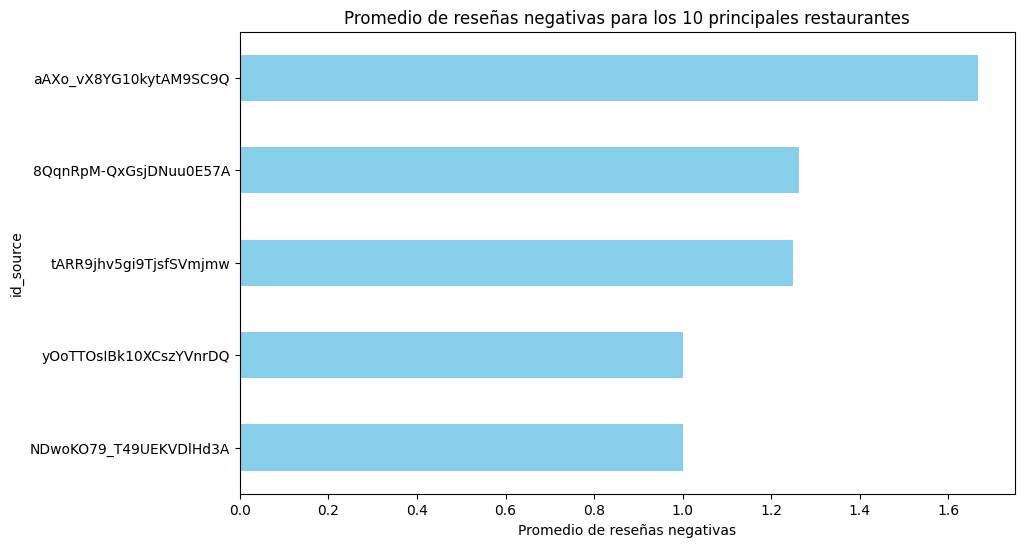

In [ ]:
# Calcular el promedio de reseñas negativas para cada restaurante
avg_negative_reviews = top_10_reviews[top_10_reviews['stars'].isin([1, 2])].groupby('id_source')['stars'].mean()

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
avg_negative_reviews.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Promedio de reseñas negativas')
plt.title('Promedio de reseñas negativas para los 10 principales restaurantes')
plt.show()

## Nos dara una idea que tipo de servicios brindan y si existe alguna correlacion con las reseñas negativas.

In [ ]:
# Obtener los business_id de los restaurantes con reseñas negativas
negative_review_ids = avg_negative_reviews.index

# Filtrar las direcciones y las coordenadas geográficas de los restaurantes en new_business usando los business_id
restaurant_locations = new_business[new_business['business_id'].isin(negative_review_ids)][['name', 'address', 'latitude', 'longitude']]

restaurant_locations

,name,address,latitude,longitude
33175,Kaffe Crepe,"1300 East Plumb Ln, Ste C4",39.504208,-119.782768
86364,Ice Dreammm Shop,"23912 State Rd 54, Ste 2",28.185100,-82.421468
130633,Sustainable Wine Tours,"27 West Anapamu St, Ste 104",34.422452,-119.705021
134154,Carlillos Cocina,415 S Rock Blvd,39.530096,-119.766608
143760,AJ's Press,3224 W Tampa Bay Blvd,27.973812,-82.496982


In [ ]:
import folium
import branca

# Crear un mapa centrado en la ubicación promedio de los restaurantes
lat_avg = restaurant_locations['latitude'].mean()
lon_avg = restaurant_locations['longitude'].mean()

# Establecer los límites de latitud y longitud para Florida
bounds = [[24.396308, -87.634643], [31.001056, -80.031362]]

# Crear un mapa con los límites establecidos
m = folium.Map(max_bounds=True, min_lat=24.396308, max_lat=31.001056, min_lon=-87.634643, max_lon=-80.031362)
m.fit_bounds(bounds)

# Añadir marcadores para cada restaurante
for idx, row in restaurant_locations.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=row['name']).add_to(m)

# Mostrar el mapa
m



## Se puede reafirmar la conclusión de que el estado de Florida es un lugar apropiado para montar un negocio en el rubro de la gastronomía, ya que prácticamente no existen reseñas negativas en el ámbito gastronómico para ese estado en particular.

## KPI 4 obtener un ratio de porcentaje de reviews considerado útil y positivas (>4) para 2025 de 80%, y el 2026 de 85%

## Se calcula:


de esta forma: $$
\text{Porcentaje de Opiniones Positivas} = \frac{\text{Opiniones Positivas}}{\text{Total Opiniones}}
$$

In [ ]:
Yelp_reviews1 = pd.read_csv("/content/drive/MyDrive/Yelp_reviews.csv", sep=",")

Yelp_reviews1

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,0,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
1,1,TP0HYy4GqYtrWMlFIhxw3A,YRsNXrlyvjnr7NLSDwen0Q,LHSTtnW3YHCeUkRDGyJOyw,1,4,2,0,We arrived a few minutes early for a 7pm reser...,2016-05-31 01:58:22
2,2,RkXe6gzU6bfut_Q2W2NpbA,jPaGpFevnH4y1BQGIe3glw,LHSTtnW3YHCeUkRDGyJOyw,5,0,0,0,This is one of my favorite restaurants. They h...,2017-12-02 23:28:30
3,3,Wv6ty8iRgaPtqRzQXQiDaA,V0RkSHN5nckzO6oPTCp6mw,LHSTtnW3YHCeUkRDGyJOyw,4,0,0,0,Let me start by saying that my wife and I are ...,2018-03-23 23:22:00
4,4,w0cb9xwH5KSgtTpP3DcIVg,yujZWE_uZn41f5-677Gvjg,LHSTtnW3YHCeUkRDGyJOyw,4,1,0,0,I wrote this a while ago but never posted it f...,2016-01-30 15:55:07
...,...,...,...,...,...,...,...,...,...,...
1820140,1820140,Rua2-9R0jNk2sAN6JdM43g,n9B9grVJBm0nSvKj0wTBNw,NSoT9z12S2wgJsZR-jfLRA,1,1,0,0,My package has been stuck in transit since Jan...,2022-01-14 22:39:21
1820141,1820141,to_ufQVO5UcKGEMsD1v8pw,OGey37DSAw5z6LLqafSt5A,NSoT9z12S2wgJsZR-jfLRA,1,1,0,0,I paid for an order to Shein on May 28th. (NOT...,2021-07-08 21:15:32
1820142,1820142,09Q32HZZf2_vJFnyHtYouQ,agyJKcnXp4PF9QBfCAKfXA,NSoT9z12S2wgJsZR-jfLRA,5,1,0,0,l A very nice driver. When I was on vacation a...,2022-01-15 20:02:35
1820143,1820143,1WYnufgEcMknv_wGI6zmCg,OGey37DSAw5z6LLqafSt5A,NSoT9z12S2wgJsZR-jfLRA,5,3,1,1,Literally like 20 minutes after i wrote a bunc...,2021-07-14 04:57:51


In [ ]:
# Convierte la columna 'date' a formato de fecha y hora
Yelp_reviews1['date'] = pd.to_datetime(Yelp_reviews1['date'])


In [ ]:
# Filtra las reseñas útiles y positivas
useful_positive_reviews = Yelp_reviews1[(Yelp_reviews1['stars'] > 4) & (Yelp_reviews1['useful'] == True)]

In [ ]:
# Crea una columna 'year' a partir de 'date'
useful_positive_reviews['year'] = useful_positive_reviews['date'].dt.year

<ipython-input-11-a52dd702a7da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_positive_reviews['year'] = useful_positive_reviews['date'].dt.year


In [ ]:
# Muestra el dataframe

useful_positive_reviews

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year
28,28,7X0prqt4teCFGnAOUIuvzg,Spt-MYqFkGXDph4ev5r--Q,LHSTtnW3YHCeUkRDGyJOyw,5,1,0,1,I went on an early Sunday afternoon and very m...,2015-09-14 23:23:26,2015
65,65,BZd7HJchxAbKpoLxUlMDEQ,GSsQ_AybkmJvT-PDh1Fchg,LHSTtnW3YHCeUkRDGyJOyw,5,1,0,1,Good food & great service on a Saturday night!...,2016-05-01 21:52:17,2016
116,116,URe-2Zlv7RoY4Ycr9JYVWw,SfMf7DEX7xT82OCcbZFsgQ,gebiRewfieSdtt17PTW6Zg,5,1,0,1,I'm very picky when it comes to Sushi. Quality...,2016-07-14 23:09:38,2016
143,143,JxgX_EbGafgSMHwdFonqLg,Z5wSVJOY5ibn5SjxmnVwSg,gebiRewfieSdtt17PTW6Zg,5,1,0,2,"Love this place. The price is right, the food ...",2016-04-26 18:02:39,2016
146,146,Pevj32bwsQAI0X0wD3k9Jg,lw3U-2VDsibjc8ii0GJH5g,gebiRewfieSdtt17PTW6Zg,5,1,0,1,Good lunch menu and sushi is half of during lu...,2016-06-27 01:30:42,2016
...,...,...,...,...,...,...,...,...,...,...,...
1820122,1820122,E2kNuVJ1darJcrnHIiCc7A,ojVRw0w2NWkobIrwSjVTbQ,ELX24jqeRWZbR-Dq6wrnLQ,5,1,0,0,This new spot is the best place to get your se...,2021-03-24 13:12:57,2021
1820128,1820128,t7ZCrgw9g4Cq07WWPOe9Yg,kpeQ1vV0J8UfOcFgTgcnZA,RROICJV1SdNKeua8QOSfhA,5,1,1,0,Jim was able to stop by the day I called (on a...,2018-02-13 14:25:46,2018
1820130,1820130,uUe4tzUbCLJFksbw82C0qg,fRZwZwBDFwSe-0MnLk0Cyw,nRh8d_hu5qUPP4MBzMS0sw,5,1,0,1,This place was so great!!! First time but won'...,2020-05-30 02:40:11,2020
1820131,1820131,qZ0bDzlfy7Sp1HIlFetNCw,xxEodKZlPiXYDumqATqWVA,nRh8d_hu5qUPP4MBzMS0sw,5,1,0,0,These people are the best. The showroom is fri...,2021-04-05 14:23:10,2021


In [ ]:
# Agrupa por 'year' y calcula el porcentaje de reseñas útiles y positivas por año
percentage_per_year = useful_positive_reviews.groupby('year').size() / Yelp_reviews1.groupby(Yelp_reviews1['date'].dt.year).size() * 100

In [ ]:
# Prepara los datos para el modelo de regresión lineal
X = percentage_per_year.index.values.reshape(-1,1)
y = percentage_per_year.values.reshape(-1,1)

In [ ]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Entrena el modelo de regresión lineal
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Haz una predicción para los años 2025 y 2026
y_pred_2025 = regressor.predict([[2025]])
y_pred_2026 = regressor.predict([[2026]])

print(f"La proyección del porcentaje de reseñas consideradas útiles y positivas (>4) para 2025 es {y_pred_2025[0][0]}%")
print(f"La proyección del porcentaje de reseñas consideradas útiles y positivas (>4) para 2026 es {y_pred_2026[0][0]}%")

La proyección del porcentaje de reseñas consideradas útiles y positivas (>4) para 2025 es 11.843168310602039%
La proyección del porcentaje de reseñas consideradas útiles y positivas (>4) para 2026 es 12.100377167569093%


## Estos resultados nos indican que, según el modelo de predicción construido, se espera que el porcentaje de reseñas que se consideran útiles y positivas (>4) sea aproximadamente del 11.84% en el año 2025 y del 12.10% en el año 2026.

## Esto significaria que, si las tendencias actuales continúan como se ha modelado, puedemos esperar que alrededor del 11.84% de las reseñas en 2025 y el 12.10% de las reseñas en 2026 sean tanto útiles como positivas (con una calificación superior a 4).


## En base a los porcentajes obtenidos se podrian considerar estrategias:

1- **Mejorar la calidad del servicio: Una forma de aumentar la cantidad de reseñas positivas es mejorando la calidad del servicio. Esto requiere mejorar la formación del personal, actualizar instalaciones, mejorar los productos y ampliar servicios que se ofrecen.**

2- **Fomentar las reseñas positivas: Se Podrías implementar un programa para alentar a los clientes satisfechos a dejar reseñas. Esto podría incluir solicitar reseñas después de una experiencia positiva o ofrecer incentivos para las reseñas.**

3- **Gestionar activamente las reseñas: Se podria responder a las reseñas negativas implementado la creacion de una aplicacion web interactiva con chat bot y gestion personal para responder en tiempo real consultas de manera oportuna y constructiva, y hacer un seguimiento de las quejas de los clientes para resolver problemas.**